# Satellite Images for Road Segmentation
Dataset: https://www.kaggle.com/datasets/sanadalali/satellite-images-for-road-segmentation

## Download kaggle dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sanadalali/satellite-images-for-road-segmentation")

print("Path to dataset files:", path)
%store path

100%|██████████| 238M/238M [00:02<00:00, 101MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sanadalali/satellite-images-for-road-segmentation/versions/1
Stored 'path' (str)


In [2]:
%store -r path
!mv $path .

## Dataset exploration

In [40]:
def find_correct_path(paths):
  for path in paths:
    if os.path.exists(path):
      return path
  return None

In [48]:
import os
import random
import tensorflow as tf
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np

PATHS = ["./satellite-images-for-road-segmentation/", "./1/"]
PATH = find_correct_path(PATHS)
HEIGHT = 256
WIDTH = 256
NUM_CLASSES = 1
KERNEL_SIZE = 5
NUM_CHANNELS = 3

In [42]:
# Utility functions to explore the dataset

def read_random_image_and_mask(parent_path, image_dir, mask_dir):
  image_files = os.listdir(parent_path + image_dir)
  random_img = random.choice(image_files)
  image_path = os.path.join(PATH + image_dir, random_img)
  mask_path = os.path.join(PATH + mask_dir, random_img)

  image = cv2.imread(image_path)
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  return image_rgb, mask

def overlay_mask(image, mask, alpha=0.7):
  color_mask = cv2.merge([mask, mask*0, mask*0])
  color_mask_rgb = cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB)
  return cv2.addWeighted(image, 1, color_mask_rgb, alpha, 0)

def LoG(image, rgb=True, kernel_size=KERNEL_SIZE):
  if rgb:
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
    grayscale = image

  blurred = cv2.GaussianBlur(grayscale, (kernel_size, kernel_size), 0)
  laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
  laplacian_abs = cv2.convertScaleAbs(laplacian)

  return laplacian_abs

In [43]:
# Show random image and its mask
IMAGE_DIR = "training/images/"
MASK_DIR = "training/groundtruth/"

image_rgb, mask = read_random_image_and_mask(PATH, IMAGE_DIR, MASK_DIR)

# Overlay mask over the image
overlay = overlay_mask(image_rgb, mask)

# Try a LoG edge detector
laplacian_abs = LoG(image_rgb)

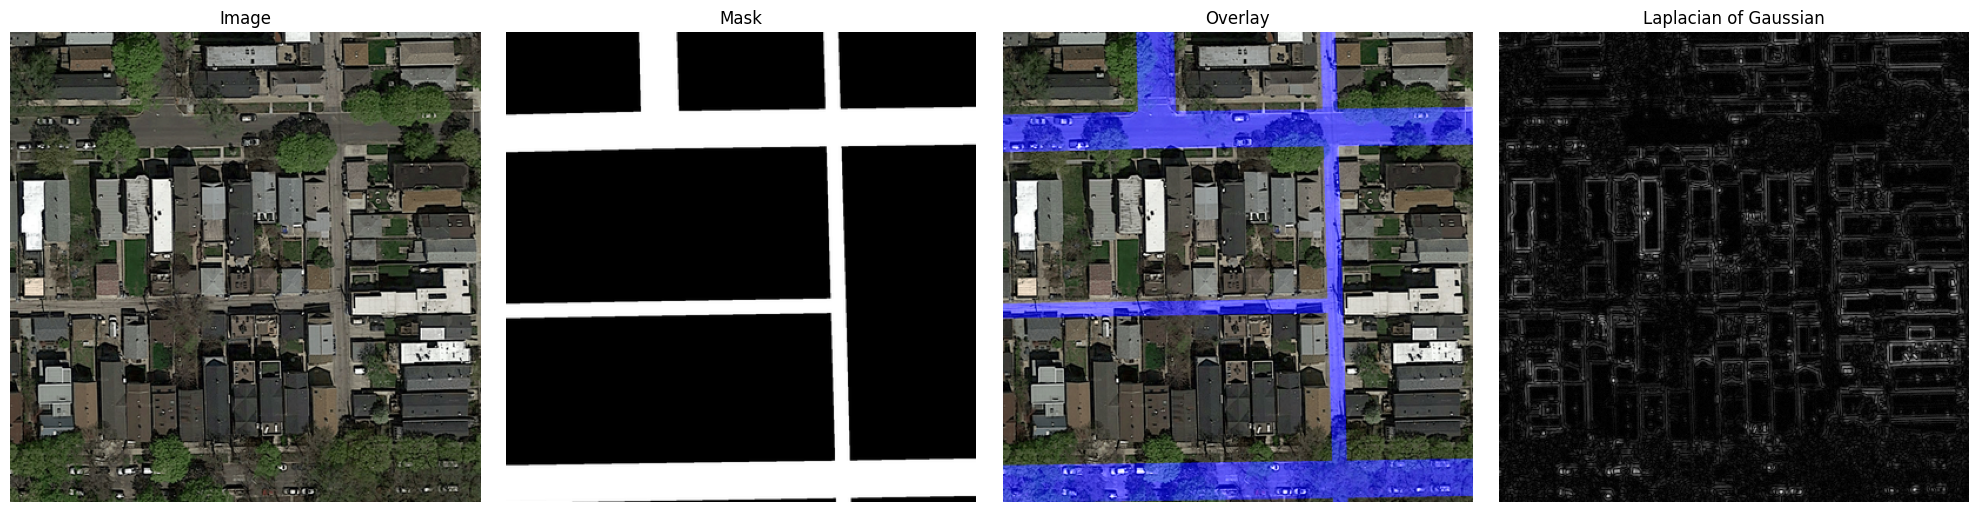

In [44]:
# Display side by side
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
images = [image_rgb, mask, overlay, laplacian_abs]
titles = ["Image", "Mask", "Overlay", "Laplacian of Gaussian"]
cmaps = [None, 'gray', None, 'gray']
for i, (image, title, cmap) in enumerate(zip(images, titles, cmaps)):
    axs[i].imshow(image, cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [45]:
# Show mask street values and the whole image values
def show_pixel_intensities(image, mask):
  street_pixels = image[mask > 0]
  fig, axs = plt.subplots(1, 2, figsize=(16, 5))

  images = [street_pixels, image_rgb.reshape(-1, image_rgb.shape[-1])]
  titles = ["Street Pixels", "Image Pixels"]
  for i, (image, title) in enumerate(zip(images, titles)):
      axs[i].hist(image, color=['red', 'green', 'blue'], edgecolor='black')
      axs[i].set_title(title)
      axs[i].set_xlabel("Pixel Intensity")
      axs[i].set_ylabel("Frequency")
      axs[i].grid(True)

  plt.tight_layout()
  plt.show()

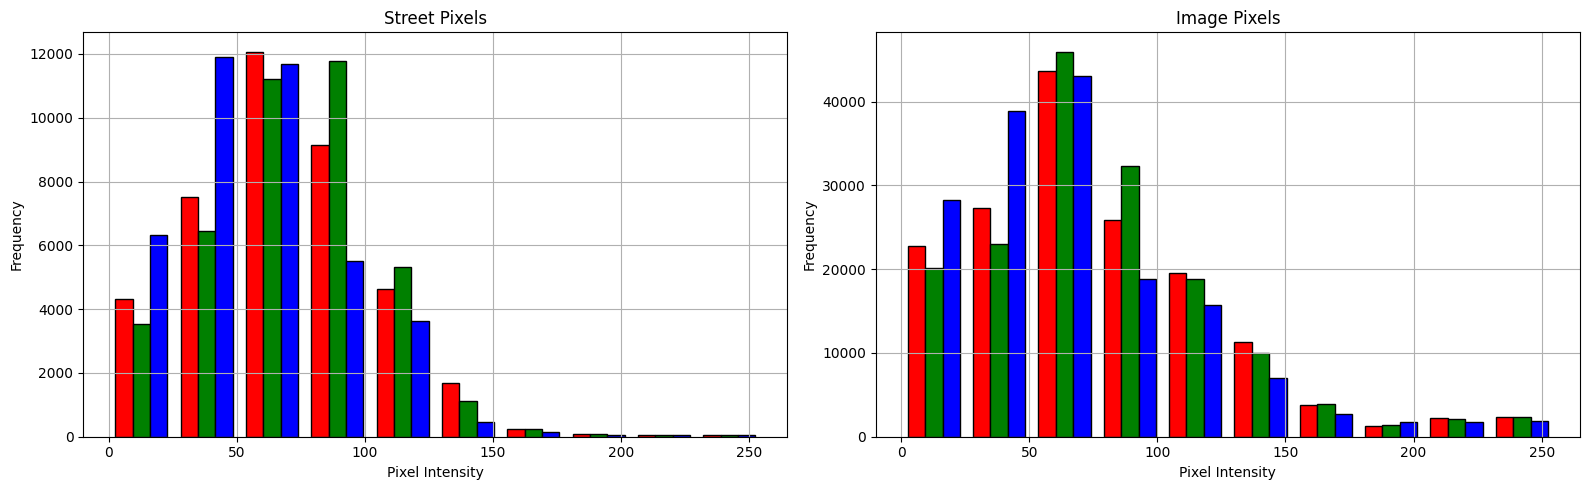

In [46]:
show_pixel_intensities(image_rgb, mask)

## First U-net try using the training set without any additional preprocessing

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv


def unet(img_size=(HEIGHT, WIDTH), num_classes=1, num_channels=3):
    inputs = Input(shape=img_size + (num_channels,))

    #Down Blocks
    conv1, pool1 = down_block(inputs, 64)
    conv2, pool2 = down_block(pool1, 128)
    conv3, pool3 = down_block(pool2, 256)

    # Bottleneck
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    #Up Blocks
    conv5 = up_block(conv4, conv3, 256)
    conv6 = up_block(conv5, conv2, 128)
    conv7 = up_block(conv6, conv1, 64)

    # Add a per-pixel classification layer
    outputs = Conv2D(num_classes, 3, activation="sigmoid", padding="same")(conv7)

    model = Model(inputs=inputs, outputs=outputs, name="unet")
    return model


# Build model
NUM_CHANNELS = 3
model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

if tf.test.gpu_device_name():
    print('TensorFlow is using GPU/TPU')
else:
    print('TensorFlow is using CPU')

In [49]:
# Scale image and set mask to 1
def rescale_image_reset_mask(input):
    image, mask = input
    image_normalized = tf.cast(image, tf.float32) / 255.0

    if mask is None:
      return (image_normalized, None)

    hard_mask = np.where(mask > 0, 1, 0)
    return (image_normalized, hard_mask)

def read_image_mask(image_path, mask_path, image_name, with_mask=True):
    image = cv2.imread(os.path.join(image_path, image_name))
    image = cv2.resize(image, (WIDTH, HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if with_mask:
      mask = cv2.imread(os.path.join(mask_path, image_name), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, (WIDTH, HEIGHT))
      return rescale_image_reset_mask((image, mask))
    return rescale_image_reset_mask((image, None))

# Create training set adding or ignoring the generated images
def create_train_test(path, shape=(HEIGHT, WIDTH), generated=False, num_img_generated=200):
  height, width = shape
  X_train_dir = path + "/training/images/"
  Y_train_dir = path + "/training/groundtruth/"
  X_test_dir = path + "/test_set_images/"
  image_files = os.listdir(X_train_dir)
  not_generated_len = len(image_files)
  random.shuffle(image_files)

  if generated:
    X_train_gen_dir = path + "/training/images_generated/"
    Y_train_gen_dir = path + "/training/groundtruth_generated/"
    image_files_gen = os.listdir(X_train_gen_dir)
    random.shuffle(image_files_gen)
    image_files_gen = image_files_gen[:num_img_generated]
    image_files += image_files_gen
    X_train = np.zeros((len(image_files), height, width, NUM_CHANNELS))
    Y_train = np.zeros((len(image_files), height, width))
    for i, image_file in enumerate(image_files[not_generated_len:]):
      image, mask = read_image_mask(X_train_gen_dir, Y_train_gen_dir, image_file)
      X_train[i + not_generated_len, :, :, :] = image
      Y_train[i + not_generated_len, :, :] = mask
  else:
    X_train = np.zeros((len(image_files), height, width, NUM_CHANNELS))
    Y_train = np.zeros((len(image_files), height, width))

  for i, image_file in enumerate(image_files[:not_generated_len]):
    image, mask = read_image_mask(X_train_dir, Y_train_dir, image_file)
    X_train[i, :, :, :] = image
    Y_train[i, :, :] = mask

  test_folders = os.listdir(X_test_dir)
  X_test = np.zeros((len(test_folders), height, width, NUM_CHANNELS))
  for i, folder in enumerate(test_folders):
    image_path = os.path.join(X_test_dir, folder)
    image, _ = read_image_mask(image_path, None, os.listdir(image_path)[0], with_mask=False)
    X_test[i, :, :, :] = image

  return X_train, Y_train, X_test

X_train, Y_train, X_test = create_train_test(PATH)
Y_train = np.expand_dims(Y_train, axis=-1)

In [ ]:
model.summary()

In [ ]:
# BinaryCrossEntropy + Dice loss
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

In [ ]:
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 1e-3

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=bce_dice_loss,
    metrics=[dice_coefficient]
)


In [ ]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

In [ ]:
Y_pred = model.predict(X_train)
Y_test = model.predict(X_test)

In [ ]:
from sklearn.metrics import jaccard_score

def evaluate_threshold(y_true, y_pred, thresholds):
    scores = np.zeros_like(thresholds)
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)

    for i, thresh in enumerate(thresholds):
      y_pred_bin = (y_pred_flat > thresh).astype(np.uint8)
      scores[i] = jaccard_score(y_true_flat, y_pred_bin)

    return scores

thresholds = np.linspace(0.1, 0.9, 41)

scores = evaluate_threshold(Y_train, Y_pred, thresholds)

In [ ]:
index = np.argmax(scores)
THRESHOLD, max_score = thresholds[index], scores[index]

plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores)
plt.plot(THRESHOLD, max_score, 'ro')
plt.xlabel('Threshold')
plt.xticks(thresholds)
plt.ylabel('IoU Score')
plt.title('Sigmoid threshold performance')
plt.show()

In [ ]:
def postprocessing(test_images, masks, threshold):
  test_images = tf.cast(test_images * 255, tf.uint8)
  masks = np.where(masks > threshold, 1, 0) * 255
  return test_images, masks

def show_test_images(test, masks, num_samples=4):
  samples = random.sample(range(len(test)), num_samples)
  fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5 * num_samples))
  for i, sample in enumerate(samples):
    axes[i, 0].imshow(test[sample][:, :, :3])
    axes[i, 0].set_title(f"Satellite Image {i+1}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(masks[sample], cmap="gray")
    axes[i, 1].set_title(f"Predicted mask {i+1}")
    axes[i, 1].axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
show_test_images(*postprocessing(X_test, Y_test, THRESHOLD))

## Same configuration but adding in the training set artificial generated satellite images

In [ ]:
# First, define a complete postprocessing function
def plot_threshold_scores(threshold, scores):
  plt.figure(figsize=(20, 5))
  plt.plot(thresholds, scores, label='IoU Score')
  plt.xlabel('Threshold')
  plt.xticks(thresholds)
  plt.ylabel('Score')
  plt.legend()
  plt.title('Threshold Performance')
  plt.show()

def full_postprocessing_test(model, X_train, Y_train, X_test, thresholds):
  Y_pred = model.predict(X_train)
  Y_test = model.predict(X_test)
  scores = evaluate_threshold(Y_train, Y_pred, thresholds)
  plot_threshold_scores(thresholds, scores)
  THRESHOLD = thresholds[np.argmax(scores)]
  show_test_images(*postprocessing(X_test, Y_test, THRESHOLD))

In [ ]:
X_train, Y_train, X_test = create_train_test(".", generated=True)
Y_train = np.expand_dims(Y_train, axis=-1)
X_train.shape, Y_train.shape

In [ ]:
model = unet(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=bce_dice_loss,
    metrics=[dice_coefficient]
)

In [ ]:
BATCH_SIZE = 16

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)

In [ ]:
full_postprocessing_test(model, X_train, Y_train, X_test, thresholds)

## Dataset adding 4th channel with probability of the street pixels intensity gaussian

In [62]:
def compute_street_distribution(images, masks):
    street_pixels = []

    for image, mask in zip(images, masks):
        reshaped_mask = np.reshape(mask, (HEIGHT, WIDTH))
        pixels = image[reshaped_mask > 0]
        if pixels.size > 0:
            street_pixels.append(pixels)

    street_pixels = np.vstack(street_pixels)
    mean = np.mean(street_pixels, axis=0)
    var = np.var(street_pixels, axis=0)

    return mean, var

In [64]:
mean, var = compute_street_distribution(X_train, Y_train)
print(f"RGB street pixel normalized mean: {mean}")
print(f"RGB street pixel variance: {var}")

RGB street pixel normalized mean: [0.33695346 0.32983179 0.29425787]
RGB street pixel variance: [0.01837859 0.01626625 0.0158709 ]


In [71]:
def add_gaussian_prob_channel(images, mean, var):
    def log_gaussian_prob(x, mean, var):
        eps = 1e-6  # To avoid division by zero
        coef = -0.5 * np.log(2 * np.pi * var + eps)
        exp_term = -0.5 * ((x - mean) ** 2) / (var + eps)
        return np.sum(coef + exp_term, axis=-1)  # Sum over RGB channels

    images_with_prob = []
    for image in images:
        # Normalize image to float32 if needed
        if image.dtype != np.float32:
            image = image.astype(np.float32)

        prob_map = log_gaussian_prob(image, mean, var)
        prob_map = prob_map[..., np.newaxis]  # Shape: HxWx1

        image_with_channel = np.concatenate([image, prob_map], axis=-1)
        images_with_prob.append(image_with_channel)

    return images_with_prob

def plot_4th_channel(image, mask):
    channel = image[..., 3]
    plt.imshow(channel, cmap='gray')
    plt.title("4th Channel: Closeness to Mean (Normalized)")
    plt.axis('off')
    plt.show()
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    plt.show()

In [72]:
X_train = add_gaussian_prob_channel(X_train, mean, var)
X_test = add_gaussian_prob_channel(X_test, mean, var)

ValueError: operands could not be broadcast together with shapes (256,256,4) (3,) 

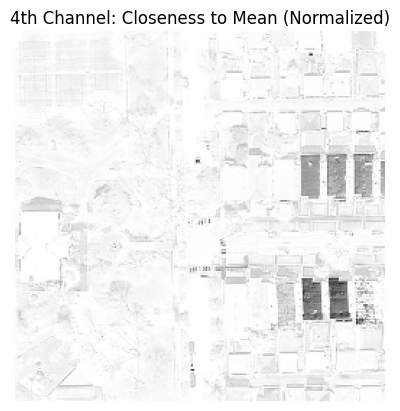

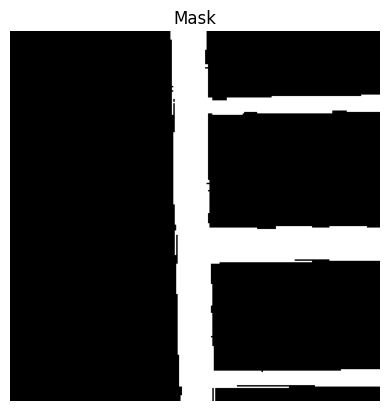

In [73]:
plot_4th_channel(X_train[0], Y_train[0])

TODO

Ruotare iimmagini e mask

Nuovo dataset

Un possibile 4th canale con la probabilità di appartenere alla gaussiana